In [4]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anusharajkumar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 191MB/s]


In [5]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


In [6]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq/"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      labels.append(label)
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels'])
data_df.head()

,image_paths,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild


In [7]:

train=data_df.sample(frac=0.7,random_state=7)
test=data_df.drop(train.index)

val=test.sample(frac=0.5,random_state=7)
test=test.drop(val.index)

In [8]:

label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
    ])

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

In [10]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

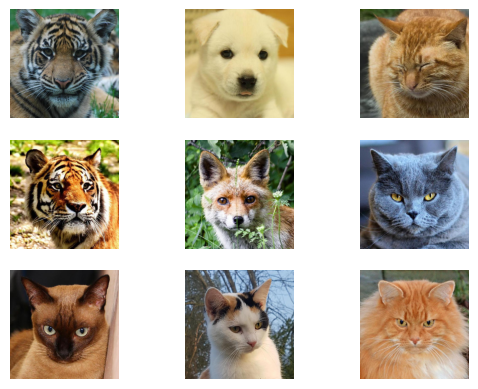

In [11]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [12]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128)
      self.output = nn.Linear(128, len(data_df['labels'].unique()))


    def forward(self, x):
      x = self.conv1(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device)

In [15]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128)
      self.output = nn.Linear(128, len(data_df['labels'].unique()))


    def forward(self, x):
      x = self.conv1(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device)

In [16]:

from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [18]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 3.4688 Train Accuracy 79.6121
              Validation Loss: 0.3705 Validation Accuracy: 90.8678
Epoch 2/10, Train Loss: 1.4948 Train Accuracy 92.1619
              Validation Loss: 0.3219 Validation Accuracy: 91.5702
Epoch 3/10, Train Loss: 0.9528 Train Accuracy 95.2263
              Validation Loss: 0.2041 Validation Accuracy: 95.2479
Epoch 4/10, Train Loss: 0.6912 Train Accuracy 96.5636
              Validation Loss: 0.2512 Validation Accuracy: 94.1736
Epoch 5/10, Train Loss: 0.4886 Train Accuracy 97.5556
              Validation Loss: 0.1712 Validation Accuracy: 95.9504
Epoch 6/10, Train Loss: 0.3877 Train Accuracy 98.1933
              Validation Loss: 0.1722 Validation Accuracy: 96.157
Epoch 7/10, Train Loss: 0.2773 Train Accuracy 98.7778
              Validation Loss: 0.1966 Validation Accuracy: 95.7851
Epoch 8/10, Train Loss: 0.2044 Train Accuracy 99.1055
              Validation Loss: 0.1778 Validation Accuracy: 96.4463
Epoch 9/10, Train Loss: 0.1369 Tr

In [19]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 96.2795 and Loss is 0.0172


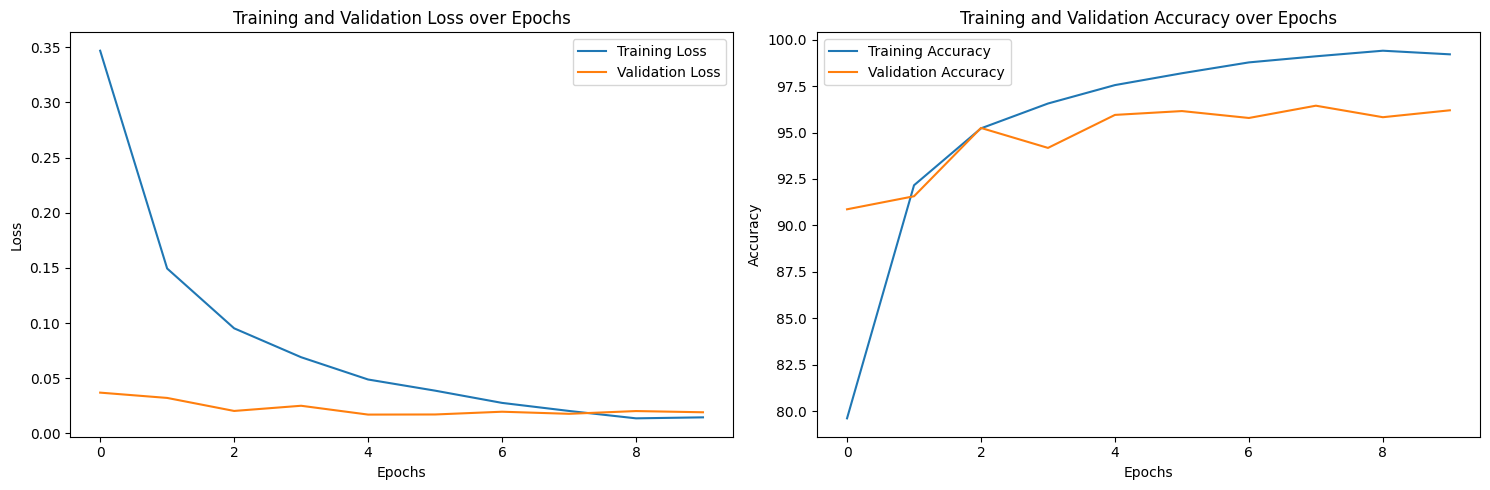

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

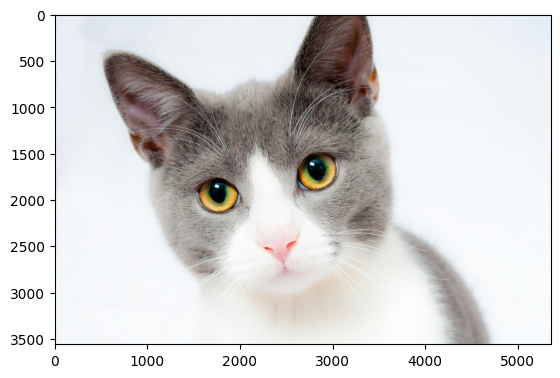


Prediction: 



array(['cat'], dtype=object)

In [30]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/drive/My Drive/pexels-pixabay-104827.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/drive/My Drive/pexels-pixabay-104827.jpg")

# New Section